> [Kaggle入门教程2-改进特征](http://www.cnblogs.com/cutd/p/5713525.html)

In [1]:
%matplotlib inline

# 改进模型
## 使用sklearn随机森林拟合非线性成分
- 用储存在**alg**的随机森林算法去做交叉验证。用predictions去预测Survived列。将结果赋值到**scores**。
- 使用**model_selection.cross_val_score**来完成这些。

In [2]:
import pandas as pd
titanic = pd.read_csv('../input/train.csv')
# 处理Age中的缺失值
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
# 量化Sex
titanic.loc[titanic['Sex'] == 'male', 'Sex'] = 0
titanic.loc[titanic['Sex'] == 'female', 'Sex'] = 1
# 量化Embarked
titanic['Embarked'] = titanic['Embarked'].fillna('S')
titanic.loc[titanic['Embarked'] == 'S', 'Embarked'] = 0
titanic.loc[titanic['Embarked'] == 'C', 'Embarked'] = 1
titanic.loc[titanic['Embarked'] == 'Q', 'Embarked'] = 2

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_val_score(alg, titanic[predictors], titanic["Survived"],cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.801346801347


# 调参
- 增加我们使用的树的数量会很大的提升预测的准确率，训练更多的树会花费更多的时间
- 调整**min_samples_split**和**min_samples_leaf**变量来减少过拟合

In [4]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.820426487093


# 生成新特征
- 一些点子：
  - 名字的长度——这和那人有多富有，所以在泰坦尼克上的位置有关。
  - 一个家庭的总人数(**SibSp**+**Parch**)。
- 使用pandas数据框的**.apply**方法来生成特征。这会对你传入数据框(dataframe)或序列(series)的每一个元素应用一个函数。我们也可以传入一个**lambda**函数使我们能够定义一个匿名函数。
- 一个匿名的函数的语法是**lambda x:len(x)**。x将传入的值作为输入值——在本例中，就是乘客的名字。表达式的右边和返回结果将会应用于x。**.apply**方法读取这些所有输出并且用他们构造出一个pandas序列。我们可以将这个序列赋值到一个数据框列。

In [5]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

## 使用头衔
- 从乘客的名字中提取出他们的头衔。头衔的格式是**Master.,Mr.,Mrs.**，以一个大写字母开头，后面是小写字母，最后以.结尾。有一些非常常见的头衔，也有一些“长尾理论”中的一次性头衔只有仅仅一个或者两个乘客使用。第一步使用**正则表达式**提取头衔，然后将每一个唯一头衔匹配成(map)整型数值。
- 之后我们将得到一个准确的和Title相对应的数值列。

In [6]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pd.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


## 家族
- 生成一个特征来表示哪些人是一个家族。因为幸存看起来非常依靠你的家族和你旁边的人，这是一个成为好特征的好机会。
- 通过FamilySize连接某些人的姓来得到一个家庭编号。然后我们将基于他们的家庭编号给每个人赋值一个代码。

In [7]:
import operator
# A dictionary mapping family name to id
family_id_mapping = {}
# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


# 找出最好的特征
- 一种方法就是使用单特征选择器(univariate feature selection),这种方法的本质是一列一列的遍历计算出和我们想要预测的结果(Survived)最密切关联的那一列。
- sklearn有一个叫做SelectKBest的函数将会帮助我们完成特征选择。这个函数会从数据中选出最好的特征，并且允许我们指定选择的数量。
- 我们已经更新predictors。为titanic数据框做用3折交叉验证预测。用predictors预测Survived列。将结果赋值给scores。
- 在做完交叉验证预测之后，将我们的scores的平均值打印出来。

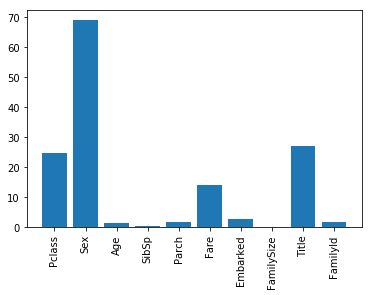

0.811447811448


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

# 梯度提升(Gradient Boosting)
- 另外一种方法是以决策树为基础的梯度提升分类器。提升包含了一个接一个的训练决策树，并且将一个树的误差传入到下一棵树。所以每一颗树都是以它之前的所有树为基础构造的。不过如果我们建造太多的树会导致过拟合。当你得到了100棵左右的树，这会非常容易过拟合和训练出数据集中的怪特征。当我们的数据集极小时，我们将会把树的数量限制在25。
- 另外一种防止过拟合的方法就是限制在梯度提升过程中建立的每一棵树的深度。我们将树的高度限制到3来分避免过拟合。
- 我们将试图用提升来替换掉我们的随机森林方法并且观察是否会提升我们的预测准确率。

# 集成(Ensembling)
- 为了提升我们的预测准确率，我们能做的一件事就是集成不同的分类器。集成的意思就是我们利用一系列的分类器的信息来生成预测结果而不是仅仅用一个。在实践中，这意味着我们是求他们预测结果的平均值。
- 通常来说，我们集成越多的越不同的模型，我们结果的准确率就会越高。多样性的意思是模型从不同列生成结果，或者使用一个非常不同的方法来生成预测结果。集成一个随机森林和一个决策树大概不会得到一个非常好的结果，因为他们非常的相似。换句话说，集成一个线性回归和一个随机森林可以工作得非常棒。
- 一个关于集成的警示就是我们使用的分类器的准确率必须都是差不多的。集成一个分类器的准确率比另外一个差得多将会导致最后的结果也变差。
- 在这一节中，我们将会集成基于大多数线性预测训练的逻辑回归(有一个线性排序，和Survived有一些关联)和一个在所有预测元素上训练的梯度提升树。
- 在我们集成的时候会保持事情的简单——我们将会求我们从分类器中得到的行概率(0~1)的平均值，然后假定所有大于0.5的匹配成1，小于等于0.5的匹配成0。

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
folder = KFold(n_splits=3, random_state=1)

predictions = []
for train, test in folder.split(titanic['Age']):
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.278338945006


# 在测试集上匹配我们的变化
- 生成NameLength,表示名字的长度。
- 生成FamilySize,表示家庭的大小。
- 添加Title列，保持和我们之前做的匹配一样。
- 添加FamilyId列，测试数据集合训练数据集的id保持一致。

In [10]:
titanic_test = pd.read_csv('../input/test.csv')

# 处理测试集
titanic_test = pd.read_csv("../input/test.csv")
titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test['Age'].median())
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Fare'].median())
titanic_test.loc[titanic_test['Sex'] == 'male', 'Sex'] = 0
titanic_test.loc[titanic_test['Sex'] == 'female', 'Sex'] = 1
titanic_test['Embarked'] = titanic_test['Embarked'].fillna('S')
titanic_test.loc[titanic_test['Embarked'] == 'S', 'Embarked'] = 0
titanic_test.loc[titanic_test['Embarked'] == 'C', 'Embarked'] = 1
titanic_test.loc[titanic_test['Embarked'] == 'Q', 'Embarked'] = 2

# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
# print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


# 在测试集上做预测
- 通过将预测结果小于等于0.5的转换成0,将大于0.5的转换成1，将所有的结果转换成非0即1。
- 然后，用.astype(int)方法将预测结果转换成整型——如果你不这样做，Kaggle将会给你0分。
- 最后，生成一个第一列是PassengerId，第二列是Survived(这就是预测结果)。

In [11]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1

In [12]:
predictions = predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })
# submission.to_csv('../input/submission.csv', index=False)

# 其他改进
## 特征方面
- 尝试用和船舱相关的特征。
- 观察家庭大小特征是否会有帮助——一个家庭中女性的数量多使全家更可能幸存？
- 乘客的国籍能为其幸存提高什么帮助？
## 算法方面
- 尝试在集成中加入随机森林分类器。
- 在这个数据上支持向量机也许会很有效。
- 可以试试神经网络。
- 提升一个不同的基础匪类器也许会更好。
## 集成方法
- 多数表决是比概率平均更好的集成方法？